In [73]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11936892049774820770, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8988704042636501253
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 9520206529341598208
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14892338381
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11030438224622593568
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [0]:
import glob
import os
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras import layers
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.python.keras.callbacks import Callback
from tensorflow.python.keras import optimizers
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import tarfile
from matplotlib import pyplot
import numpy as np 
from io import BytesIO
import PIL
from IPython.display import display, Image


In [0]:
fname = 'train.tar.gz'
if (fname.endswith("tar.gz")):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()

In [76]:


processed_imgs = []
hot_dogs_paths = glob.glob("./train/hot_dog/*.jpg")
not_hot_dogs_paths = glob.glob("./train/not_hot_dog/*.jpg")
y = []
def process_img(img_path):
  img = image.load_img(img_path, target_size=(224, 224))
  x = image.img_to_array(img)
  return x
  
for img_path in hot_dogs_paths:
  processed_imgs.append(process_img(img_path))
  y.append(1)
for img_path in not_hot_dogs_paths:
  processed_imgs.append(process_img(img_path))
  y.append(0)
  
processed_imgs = np.stack(processed_imgs)
std = processed_imgs.std()
print('std:', std)
mean = processed_imgs.mean()
print('mean:', mean)

processed_imgs = (processed_imgs - mean) / std
y = np.array(y)

 

std: 71.027534
mean: 110.0263


In [77]:
processed_imgs[3]

array([[[-0.3382674 ,  0.05594593,  0.5768707 ],
        [-0.3382674 ,  0.01370879,  0.5768707 ],
        [-0.26787215,  0.05594593,  0.6331869 ],
        ...,
        [-0.2819512 ,  0.2530526 ,  0.77397734],
        [-0.2819512 ,  0.18265735,  0.6472659 ],
        [-0.39458358, -0.0144493 ,  0.39384305]],

       [[-0.3101093 ,  0.05594593,  0.5768707 ],
        [-0.2819512 ,  0.04186688,  0.6191078 ],
        [-0.2819512 ,  0.02778784,  0.60502875],
        ...,
        [-0.225635  ,  0.2812107 ,  0.7880564 ],
        [-0.15523978,  0.2812107 ,  0.71766114],
        [-1.0844569 , -0.7184017 , -0.3382674 ]],

       [[-0.26787215,  0.07002497,  0.60502875],
        [-0.2819512 ,  0.02778784,  0.60502875],
        [-0.2537931 ,  0.01370879,  0.60502875],
        ...,
        [-0.2537931 ,  0.2248945 ,  0.71766114],
        [-0.0426074 ,  0.33752686,  0.7458192 ],
        [-1.5349864 , -1.2252474 , -0.8873502 ]],

       ...,

       [[-1.408275  , -1.2674845 , -1.0985359 ],
        [-1

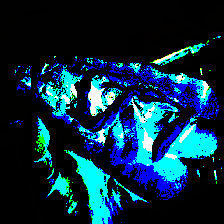

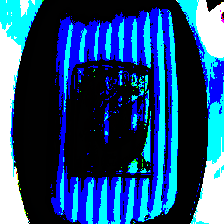

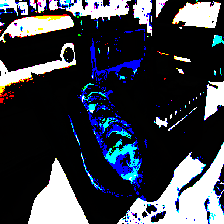

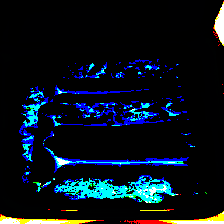

In [78]:
def display_img_array(ima):
    im = PIL.Image.fromarray(np.uint8(ima))
    bio = BytesIO()
    im.save(bio, format='png')
    display(Image(bio.getvalue(), format='png'))

for array in processed_imgs[:4]:
  display_img_array(array)


In [79]:
y.shape
processed_imgs.shape


(998, 224, 224, 3)

In [0]:
batch_size = 16
num_classes = 2
SEED = 67
epochs = 45
if not os.path.exists(os.path.join(os.getcwd(), 'models')):
  os.makedirs(os.path.join(os.getcwd(), 'models'))
save_dir = os.path.join(os.getcwd(), 'models')
model_name = 'keras_cnn_model.h5'

In [0]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=processed_imgs.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(224))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [0]:
class Metrics(Callback):
    def set_val_data(self, x_val, y_val):
        self.x_val = x_val
        self.y_val = y_val
        
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
   
    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.x_val, self.y_val
        y_pred = self.model.predict(X_val)

        y_pred_cat = y_pred.argmax(axis=1)
        _val_f1 = f1_score(y_val, y_pred_cat, average='macro')
        _val_recall = recall_score(y_val, y_pred_cat, average='macro')
        _val_precision = precision_score(y_val, y_pred_cat, average='macro')

        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)

        print((f"val_f1: {_val_f1:.4f}"
               f" — val_precision: {_val_precision:.4f}"
               f" — val_recall: {_val_recall:.4f}"))

        return


In [83]:

def lr_schedule(epoch):
    lr = 1e-3
    if epoch >= 43:
        lr = 1e-5
    elif epoch >= 37:
        lr = 1e-4
    print('Learning rate: ', lr)
    return lr

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy']
)
np.random.seed(SEED)
X_train, X_val, y_train, y_val = train_test_split( 
    processed_imgs, y, test_size=0.1, random_state=SEED)
f1_metrics = Metrics()
f1_metrics.set_val_data(X_val, y_val)


hist = model.fit(
    X_train, 
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[f1_metrics]
)



Epoch 1/45
898/898 [==============================] - 5s 6ms/sample - loss: 0.7924 - acc: 0.5056
Epoch 2/45
 32/898 [>.............................] - ETA: 3s - loss: 0.7103 - acc: 0.4062

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


898/898 [==============================] - 4s 5ms/sample - loss: 0.6891 - acc: 0.5445
Epoch 3/45
898/898 [==============================] - 4s 5ms/sample - loss: 0.6830 - acc: 0.5690
Epoch 4/45
898/898 [==============================] - 4s 5ms/sample - loss: 0.6634 - acc: 0.6080
Epoch 5/45
898/898 [==============================] - 4s 5ms/sample - loss: 0.6521 - acc: 0.6125
Epoch 6/45
898/898 [==============================] - 4s 5ms/sample - loss: 0.6352 - acc: 0.6637
Epoch 7/45
898/898 [==============================] - 4s 5ms/sample - loss: 0.6452 - acc: 0.6537
Epoch 8/45
898/898 [==============================] - 4s 5ms/sample - loss: 0.6148 - acc: 0.6782
Epoch 9/45
898/898 [==============================] - 4s 5ms/sample - loss: 0.6056 - acc: 0.6804
Epoch 10/45
898/898 [==============================] - 4s 5ms/sample - loss: 0.5863 - acc: 0.7127
Epoch 11/45
898/898 [==============================] - 4s 4ms/sample - loss: 0.5793 - acc: 0.7094
Epoch 12/45
898/898 [==================

In [84]:
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)



Saved trained model at /content/models/keras_cnn_model.h5 


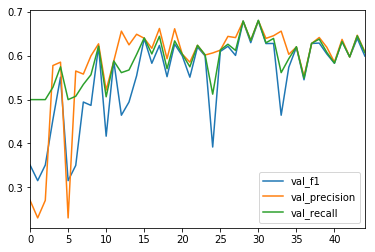

In [85]:
history_df = pd.DataFrame(hist.history)
history_df['val_f1'] = f1_metrics.val_f1s
history_df['val_precision'] = f1_metrics.val_precisions
history_df['val_recall'] = f1_metrics.val_recalls


history_df[['val_f1', 'val_precision', 'val_recall']].plot()



In [0]:
import tarfile

def make_tarfile(output_filename, source_dir):
    with tarfile.open(output_filename, "w:gz") as tar:
        tar.add(source_dir, arcname=os.path.basename(source_dir))
make_tarfile('model.tar.gz', model_path)